In [1]:
import scipy.io
import numpy as np
from tqdm import tqdm
from harp_beam import compute_EEPs, power_EEPs, stefcal, compute_beamforming, beamforming, to_dBV
from plots import plot2, plot_stefcal, plot_beamforming_results, plot_station_beam_pattern, plot_stefcal_comparison

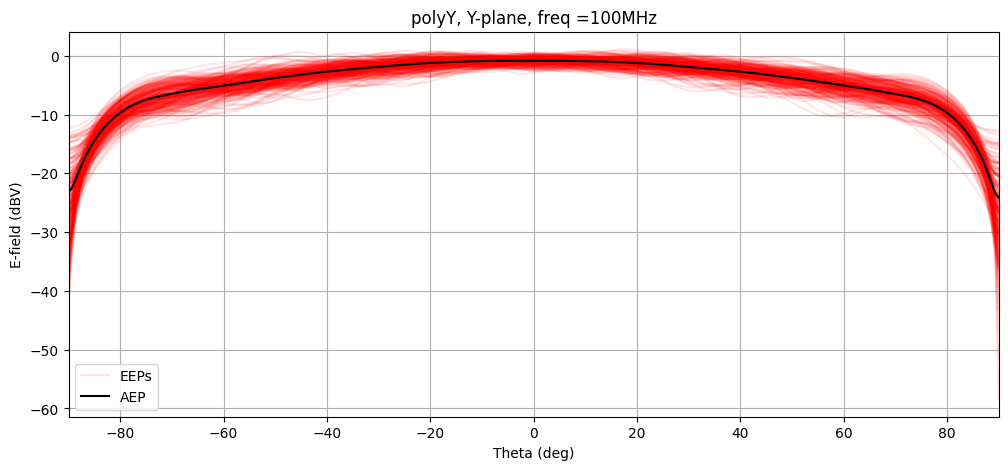

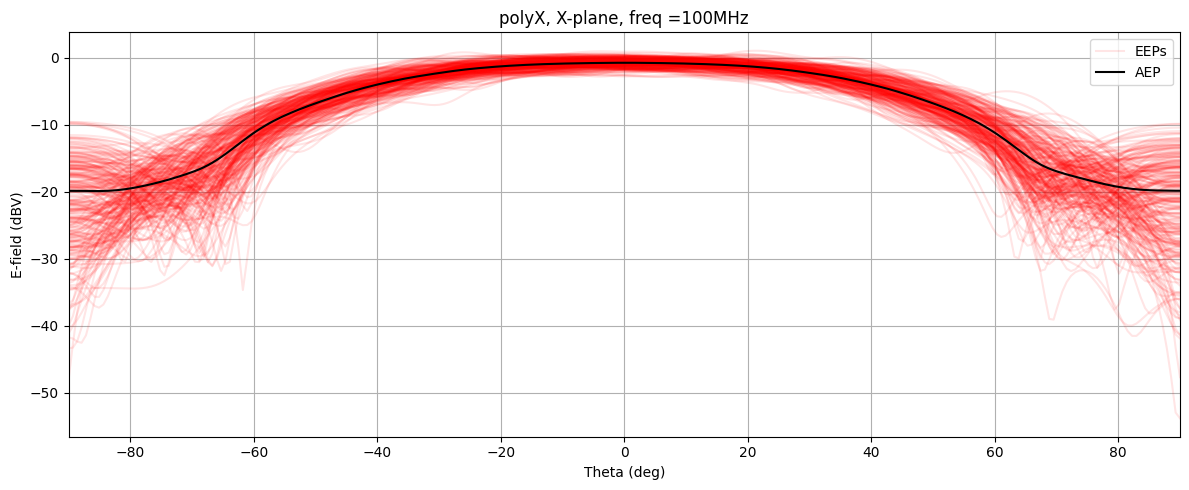

In [2]:
## Q 2. plot all the 256 EEPs and their average (AEP)

num_dir = 256
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = np.zeros_like(theta)

v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Compute EEPs
complex_E_fields = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Compute power EEPs
power_E_fields = power_EEPs(*complex_E_fields)

# plot EEPs and AEPs
plot2(theta, *power_E_fields)

In [3]:
## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as

filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs

In [4]:
# Q3/4 StEFCal algorithm
def stefcal(M, R, g_sol, max_iteration=1000, threshold=1e-5, algorithm2=False):
    convergence = []
    abs_gain_error = []
    abs_amp_error = []
    abs_phase_error = []

    # Number of antennas
    N = R.shape[0]

    # Initial gain matrix G
    G = np.eye(N, dtype=complex) # Identity matrix

    # Iterative loop
    for i in tqdm(range(max_iteration)):

        # Last iteration of G for comparison
        G_prev = G.copy()

        for p in range(N):  # Loop over antennas p
            if algorithm2:
                z = np.dot(G, M[:, p])  # Use G[i]
            else:
                z = np.dot(G_prev, M[:, p])  # Use G[i-1]
            gp = np.dot(np.conjugate(R[:, p]), z) / np.dot(np.conjugate(z), z)  # Calculate new gain for antenna p
            G[p, p] = gp # Update the gain for antenna p in the matrix


        # Convergence check even iterations
        if i % 2 == 0:
            
            delta_G = np.linalg.norm(G - G_prev, 'fro') / np.linalg.norm(G, 'fro')
            convergence.append(delta_G)
            if delta_G < threshold:
                print(f"Convergence reached after {i+1} iterations.")
                break
            else:
                G = (G + G_prev) / 2
                
                # Calculate errors
                G_diagonal = G.diagonal().reshape(-1, 1)
                abs_gain_error.append(np.linalg.norm(np.abs(G_diagonal - g_sol), 'fro') / np.linalg.norm(g_sol, 'fro'))
                abs_amp_error.append(np.linalg.norm(np.abs(G_diagonal) - np.abs(g_sol), 'fro') / np.linalg.norm(g_sol, 'fro'))
                abs_phase_error.append(np.linalg.norm(np.angle(G_diagonal) - np.angle(g_sol), 'fro')/ np.linalg.norm(g_sol, 'fro'))

    return G, convergence, abs_gain_error, abs_amp_error, abs_phase_error

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 230/1000 [00:01<00:05, 144.78it/s]


Convergence reached after 231 iterations.


 19%|█▉        | 192/1000 [00:01<00:04, 166.04it/s]


Convergence reached after 193 iterations.


 14%|█▍        | 142/1000 [00:00<00:05, 147.80it/s]


Convergence reached after 143 iterations.


 12%|█▏        | 120/1000 [00:00<00:05, 164.41it/s]


Convergence reached after 121 iterations.


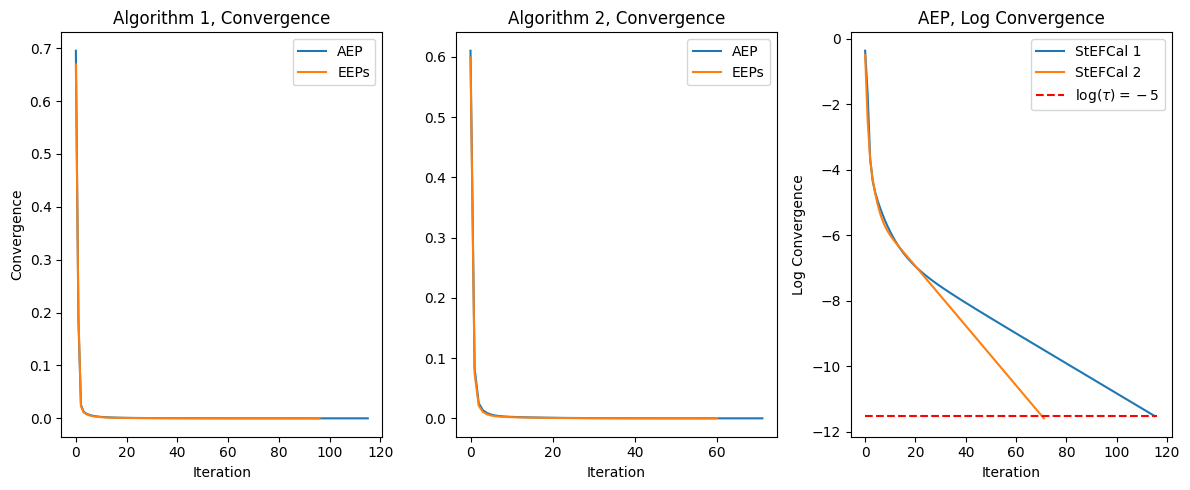

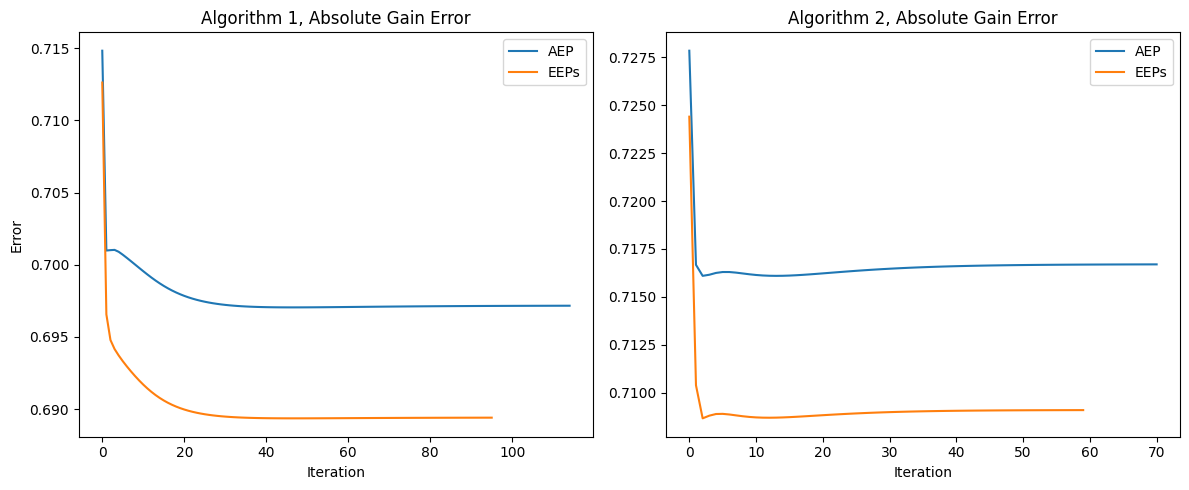

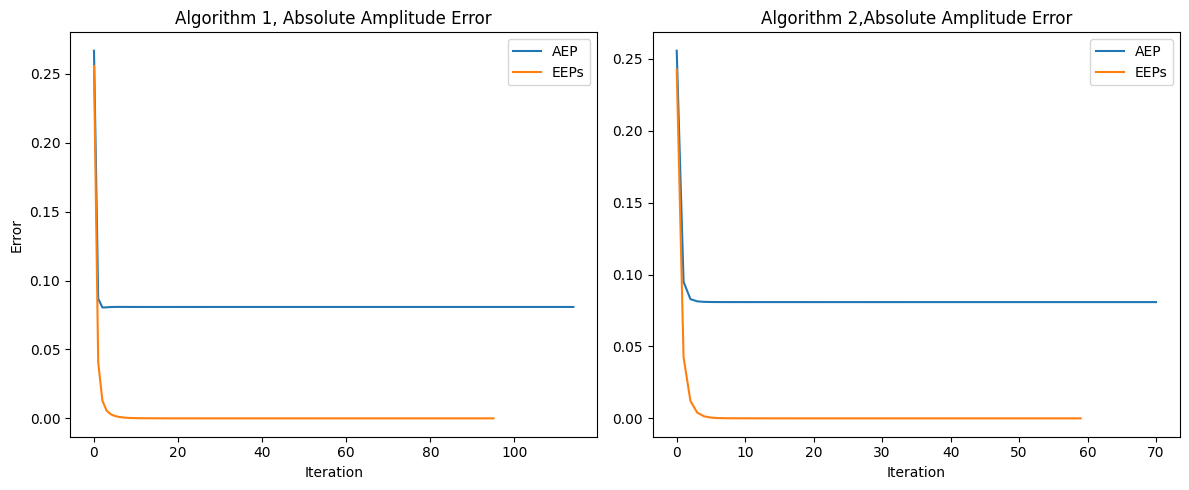

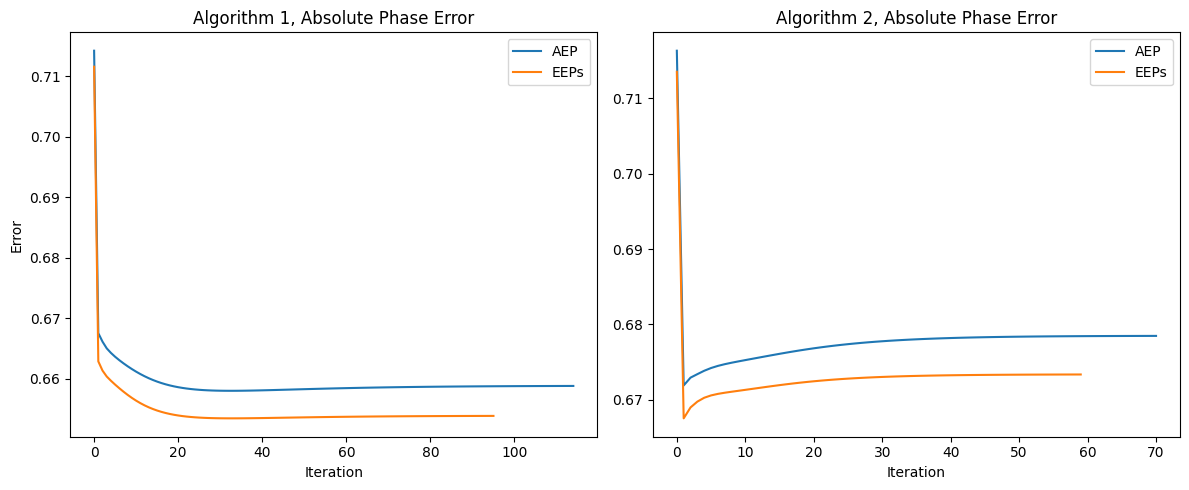

In [5]:
## Algorithm 1
# run stefcal
G_AEP1, *algo1_AEP = stefcal(M_AEP, R, g_sol)
G_EEPs1, *algo1_EEP = stefcal(M_EEPs, R, g_sol) 


## Algorithm 2
# run stefcal
G_AEP2, *algo2_AEP = stefcal(M_AEP, R, g_sol, algorithm2=True)
G_EEPs2, *algo2_EEP = stefcal(M_EEPs, R, g_sol, algorithm2=True)

# plot stefcal
plot_stefcal_comparison(algo1_AEP, algo1_EEP, algo2_AEP, algo2_EEP)

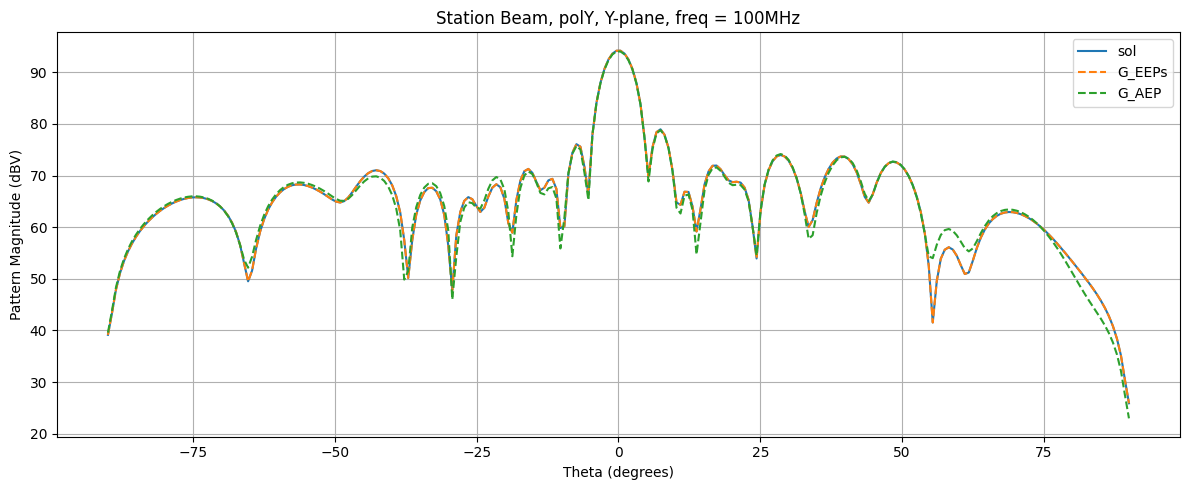

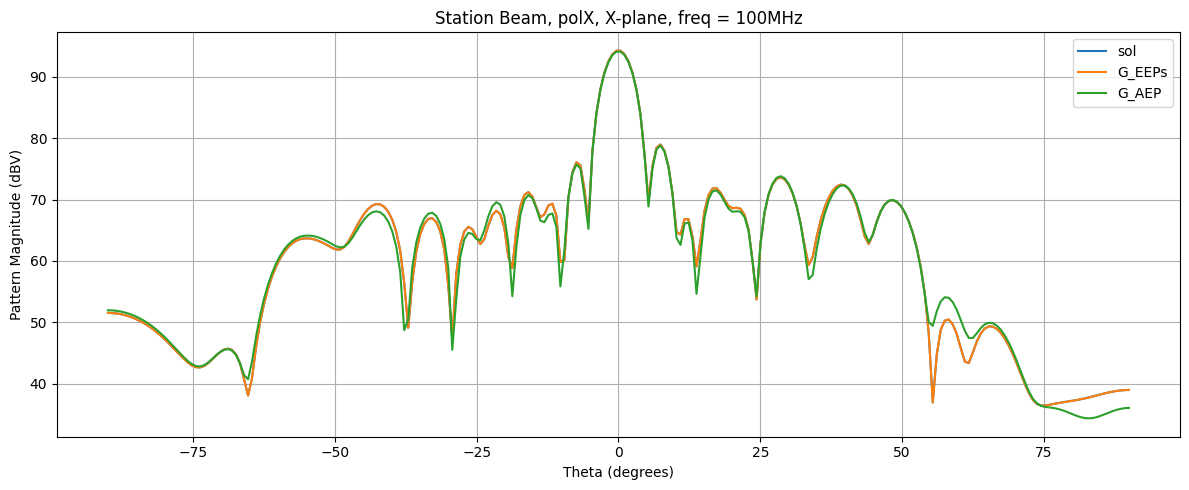

In [6]:
# Q 5. Calibrating EEP using Array Pattern

freq = 100
c0 = 299792458  # speed of light
k0 = 2 * np.pi * freq / c0 * 10**6  # wavenumber
antenna = 'SKALA41'  # antenna name
layout = 'random'  # array layout
data_folder = 'harp_beam'
filename_eep = f"data_EEPs_{antenna}_{layout}_{freq}MHz.mat"
mat = scipy.io.loadmat(filename_eep)
pos_ant = np.array(mat['pos_ant'])

# Define theta_range based on your system (same as your original theta_range)
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = 0
theta0 = 0  # Define theta0 based on your system
phi0 = 0  # Define phi0 based on your system


# AP g_sol
AP_sol_polY, AP_sol_polX = compute_beamforming(g_sol, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP g_EEPs
AP_g_EEPs_polY, AP_g_EEPs_polX = compute_beamforming(g_EEPs, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP g_AEP
AP_g_AEP_polY, AP_g_AEP_polX = compute_beamforming(g_AEP, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP G_EEPs1
AP_G_EEPs_polY, AP_G_EEPs_polX = compute_beamforming(G_EEPs1.diagonal().reshape(-1,1), *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP G_AEP1
AP_G_AEP_polY, AP_G_AEP_polX = compute_beamforming(G_AEP1.diagonal().reshape(-1,1), *complex_E_fields, pos_ant, theta, phi, theta0, phi0)


# Plot beamforming results
plot_beamforming_results(theta, [AP_sol_polY, AP_G_EEPs_polY, AP_G_AEP_polY],
                        [AP_sol_polX, AP_G_EEPs_polX, AP_G_AEP_polX],
                        ['g_sol', 'G_EEPs', 'G_AEP'],
                        ['solid', 'dashed', 'dashed'],)